# Objective:

Designing a 8 hours ahead water inflow forecast.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from os.path import abspath

from sklearn.preprocessing import PolynomialFeatures

from darts import TimeSeries
from darts.utils.missing_values import extract_subseries, fill_missing_values
from darts.models.forecasting.xgboost import XGBModel
from darts.metrics import rmse

In [2]:
target = "FB20F11_81"


def plot_lagged_variables_comparison(data, var1, var2, lags):
    if var2 is None:
        var2 = var1

    list_of_dfs = []
    for lag in lags:
        list_of_dfs.append(
            pd.DataFrame(
                {
                    var1: data[var1].values,
                    f"lagged_{var2}": data[var2].shift(lag).values,
                    "lag_order": f"L{lag}",
                }
            )
        )

    sns.lmplot(
        pd.concat(list_of_dfs),
        x=f"lagged_{var2}",
        y=var1,
        hue="lag_order",
        markers=".",
        scatter_kws=dict(alpha=0.3),
    )


def find_flat_periods(series: pd.Series, min_span_length: int, min_delta: float):
    """
    Find periods where the value of the series does not change at least `min_delta` within `min_span_length` steps.

    Returns:
    List of tuples: Each tuple contains the start and end index of a stable period.
    """
    stable_periods = []
    start_idx = None

    for i in range(len(series) - 1):
        if abs(series.iloc[i + 1] - series.iloc[i]) < min_delta:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None and i - start_idx > min_span_length:
                stable_periods.append((start_idx, i - 1))
            start_idx = None

    # Capture any ongoing stable period at the end
    if start_idx is not None:
        stable_periods.append((start_idx, len(series) - 1))

    return stable_periods


TEMPORAL_RESOLUTION = 24  # hours


def resample_data(df: pd.DataFrame):
    return df.resample(f"{TEMPORAL_RESOLUTION}h", closed="right").agg(
        {
            target: "mean",
            "acc_precip": "sum",
            "mean_radiation": "sum",
            "mean_temp": "mean",
        }
    )


def apply_transforms(df: pd.DataFrame):
    df[target] = df[target].apply(np.log1p)
    df["mean_radiation"] = df["mean_radiation"].apply(np.log1p)
    df["acc_precip"] = (
        df["acc_precip"]
        .apply(np.log1p)
        .rolling(int(2 * (TEMPORAL_RESOLUTION / 24)), center=True)
        .mean()
    )

    return df


def plot_timeseries_by_unit(data):
    with open("./units.json", "r") as f:
        units = json.load(f)

    dfmelt = data.melt(ignore_index=False)
    dfmelt["unit"] = dfmelt["component"].map(units)

    sns.relplot(
        dfmelt.reset_index(),
        x="time",
        y="value",
        row="unit",
        kind="line",
        hue="component",
        facet_kws=dict(sharey=False),
        aspect=5,
    )

## Loading data

In [3]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")
data = inflow.merge(climate, left_index=True, right_index=True, how="inner")

data.head()

,FB20F11_81,acc_precip,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass,temp_soil_10,temp_soil_30
time,,,,,,,,,
2023-09-21 10:00:00+00:00,974.452333,0.0,998.4,535.0,68.5,20.8,20.5,15.0,14.6
2023-11-01 05:00:00+00:00,1701.950500,0.0,1005.4,0.0,98.0,-3.4,-3.6,8.2,9.7
2023-11-07 08:00:00+00:00,1338.937500,0.0,1000.8,53.0,98.3,4.0,1.3,8.5,9.5
2023-11-07 09:00:00+00:00,2243.327667,0.0,1001.1,162.0,98.5,7.6,5.6,8.5,9.4
2023-11-07 10:00:00+00:00,1988.214167,0.0,1001.7,166.0,95.5,8.6,9.5,8.4,9.4


In [4]:
data = data[[target, "mean_radiation", "mean_temp", "acc_precip"]].copy()

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


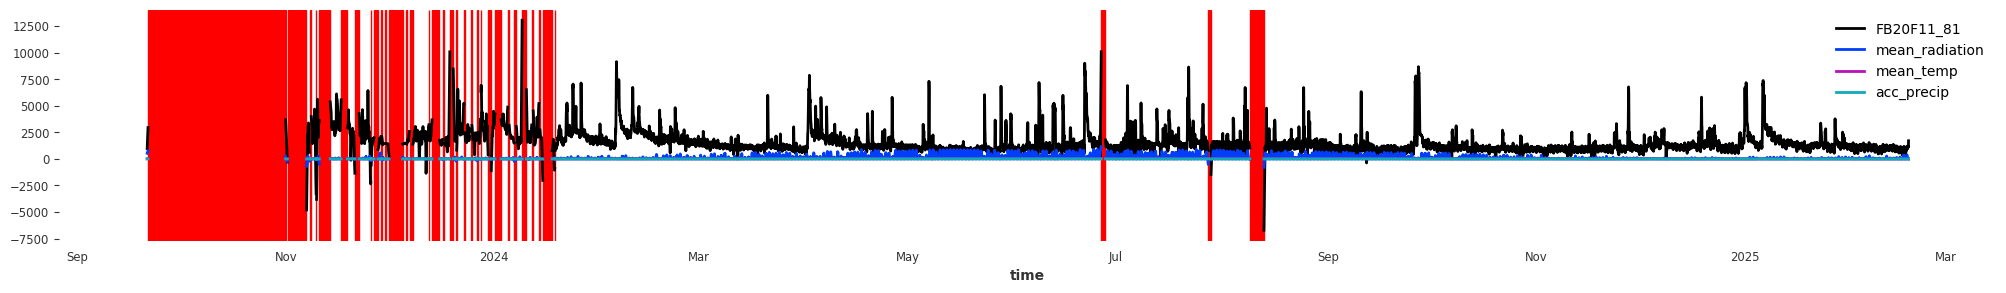

In [5]:
ts = TimeSeries.from_dataframe(data, freq="h")
ts = fill_missing_values(ts, limit=6, method="polynomial", order=2)

fig, ax = plt.subplots(1, 1, figsize=(25, 3))
ts.plot(ax=ax)
for i, row in ts.gaps(mode="any").iterrows():
    ax.axvspan(xmin=row["gap_start"], xmax=row["gap_end"], color="red")
ax.grid(visible=False)

We see there are many gaps at the beginning of the dataset, so we remove the beginning.

In [6]:
# cutoff_date = pd.Timestamp(day=28, month=1, year=2024, tz="UTC")
data = data.loc[
    :,  # data.index > cutoff_date,
    [target, "acc_precip", "mean_temp", "mean_radiation"],
]

period_length = 10  # hours
min_delta = 3
stable_periods = find_flat_periods(
    data[target], min_span_length=period_length, min_delta=min_delta
)
stable_idx = [l for idx in stable_periods for l in list(range(*idx))]

data.loc[data.index[stable_idx], target] = np.NaN

# There are instances with flow close to zero, which we assume is an error
cutoff_flow = 1
data.loc[data[target] < cutoff_flow, target] = np.NaN

ts = TimeSeries.from_dataframe(data, freq="h")
subdfs = [
    apply_transforms(resample_data(s.pd_dataframe())).dropna()
    for s in extract_subseries(ts, mode="any")
]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


<Axes: xlabel='time'>

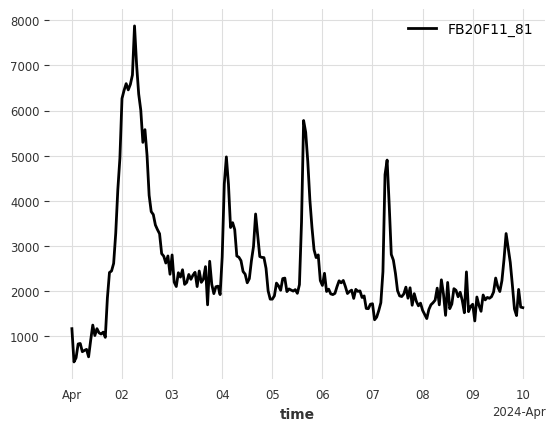

In [16]:
ts[target].slice(pd.Timestamp("2024-04-01"), pd.Timestamp("2024-04-10")).plot()

<Axes: xlabel='time'>

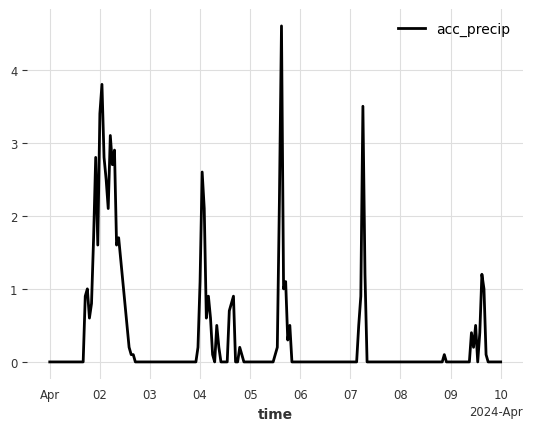

In [17]:
ts["acc_precip"].slice(pd.Timestamp("2024-04-01"), pd.Timestamp("2024-04-10")).plot()

In [49]:
daily_data = pd.concat([df for df in subdfs if len(df) > 10], axis=0)
ts = TimeSeries.from_dataframe(daily_data, freq="D")

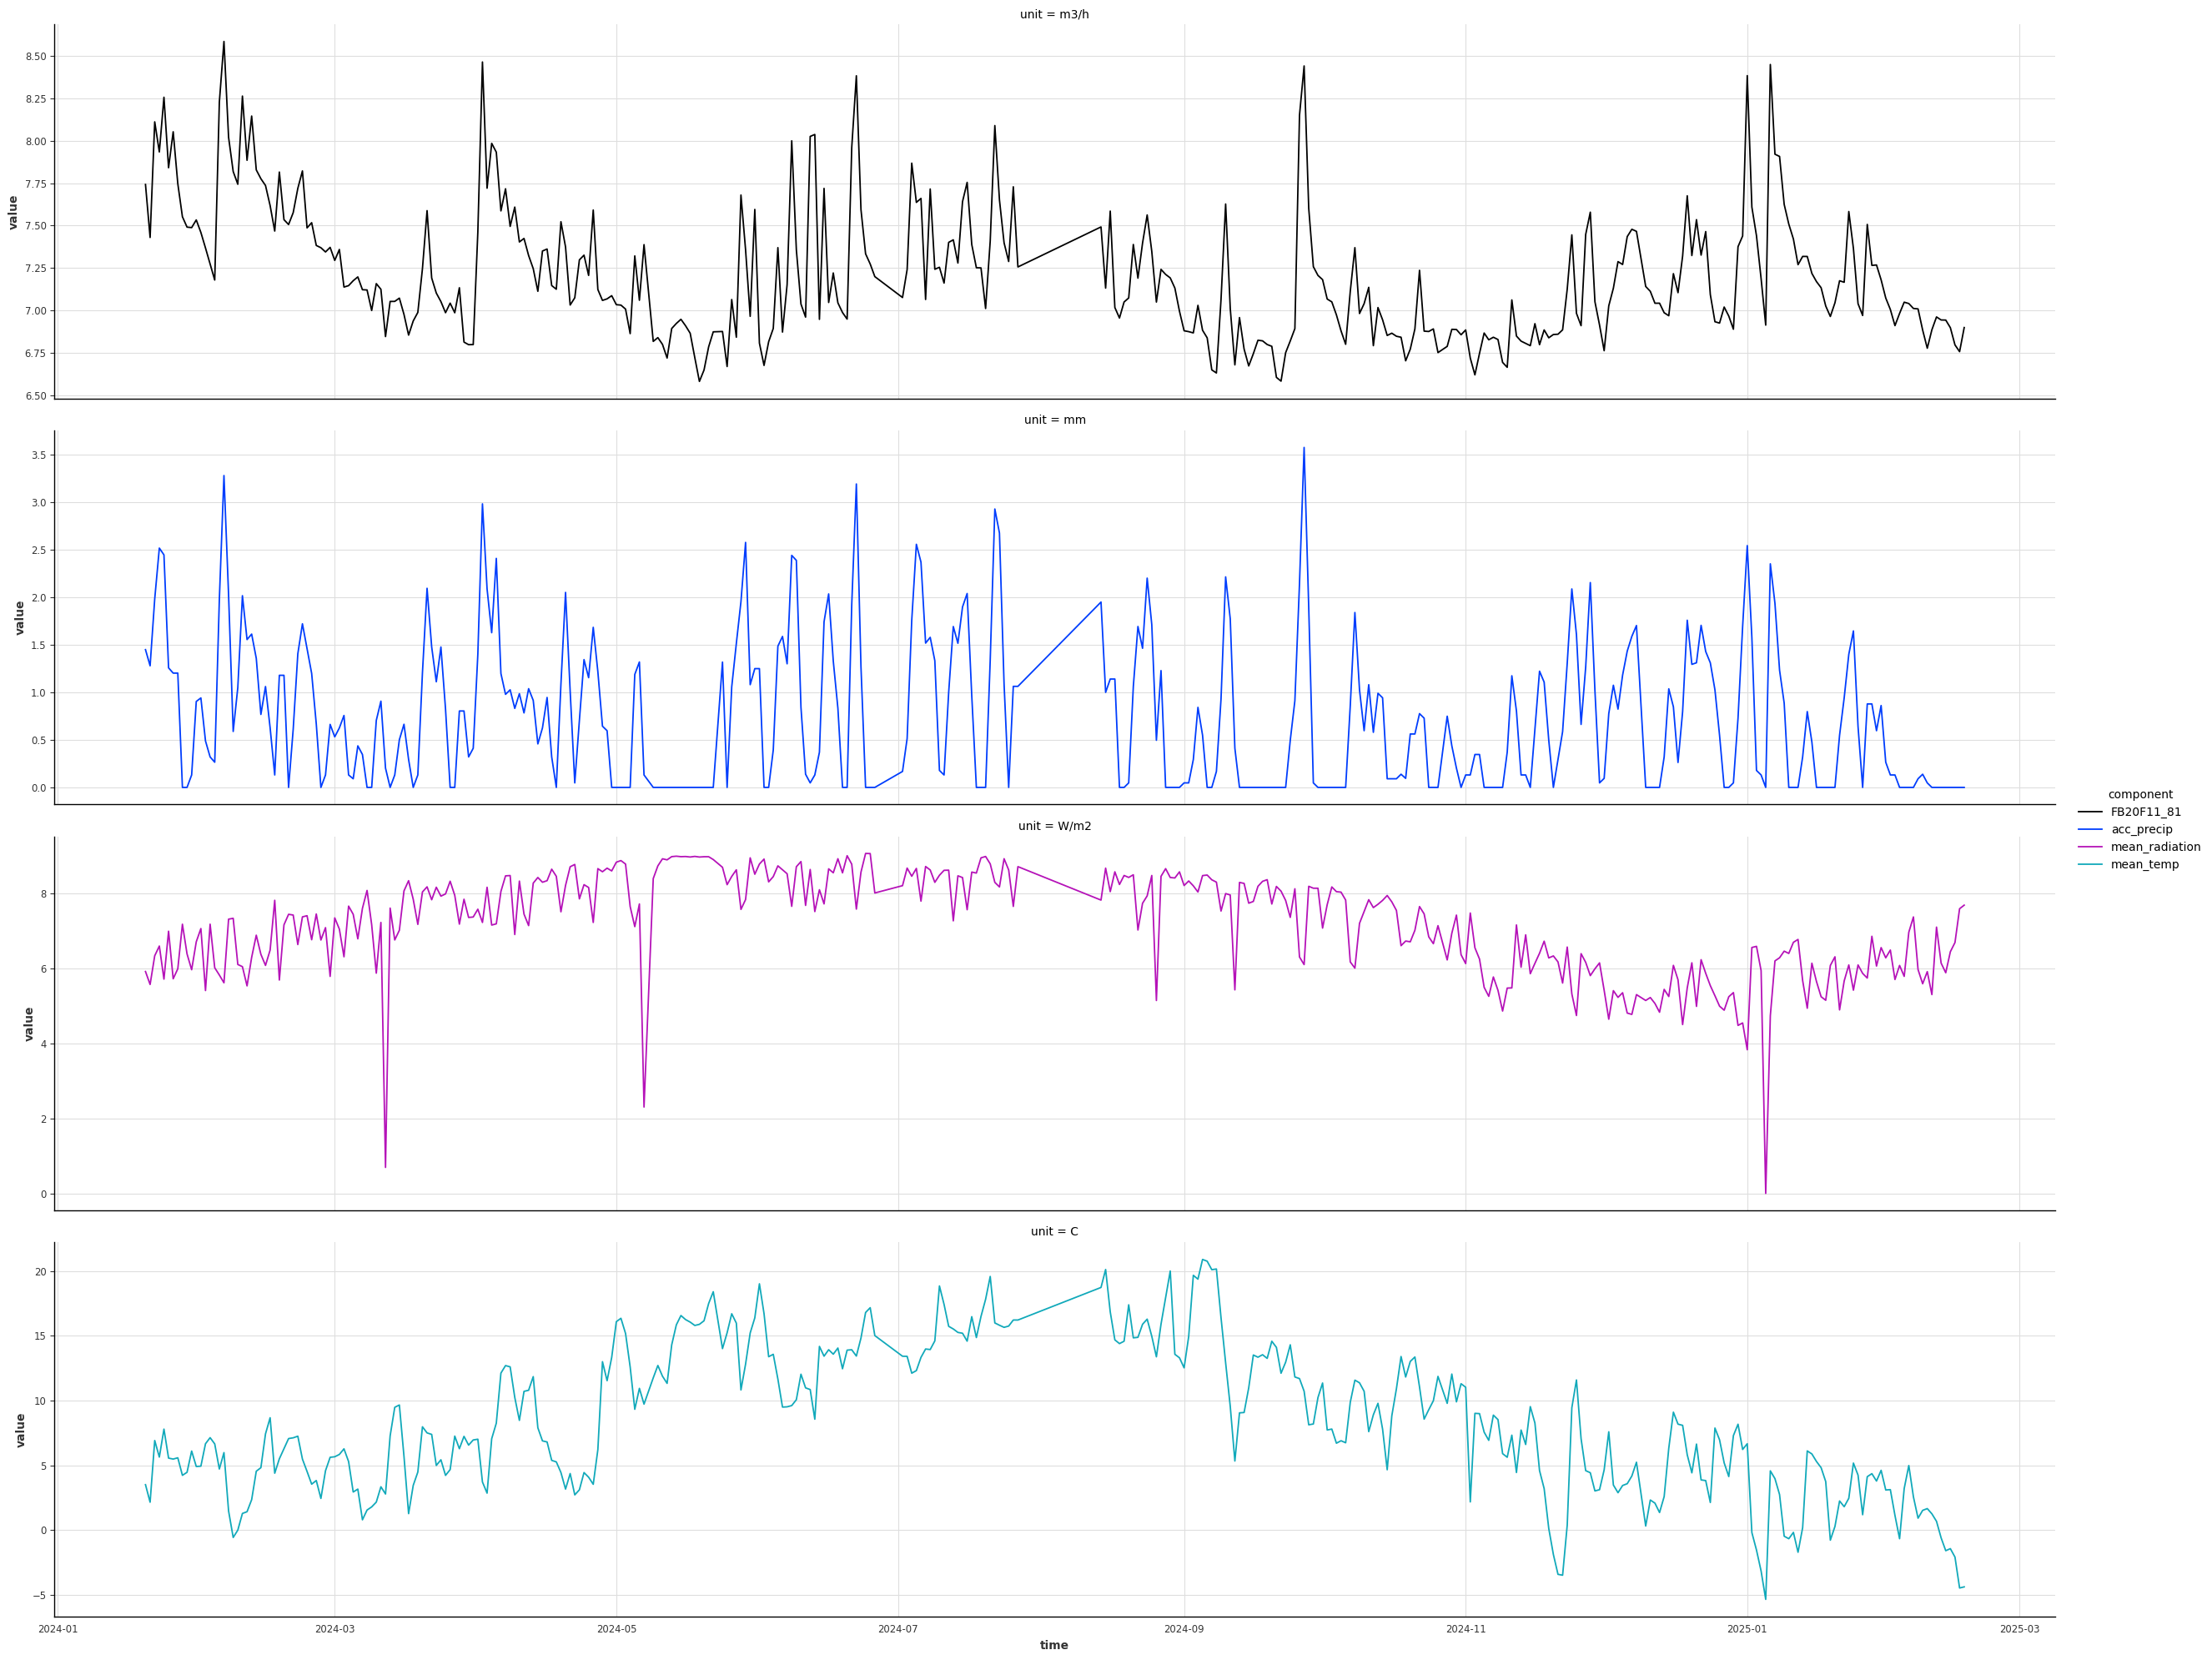

In [50]:
plot_timeseries_by_unit(daily_data)

In [51]:
poly_values = PolynomialFeatures(degree=2, include_bias=False).fit_transform(
    daily_data.drop(columns=target).values
)
poly_features = pd.DataFrame(
    poly_values,
    columns=[f"feature_{i}" for i in range(poly_values.shape[1])],
    index=daily_data.index,
)

ts_poly = TimeSeries.from_dataframe(
    poly_features.merge(daily_data[[target]], left_index=True, right_index=True),
    freq="D",
)

In [52]:
subseries = extract_subseries(ts_poly)

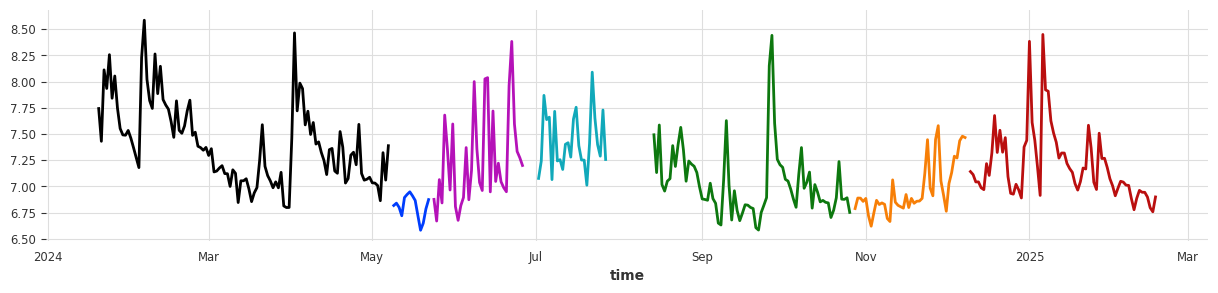

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for s in subseries:
    s[target].plot(ax=ax)
ax.legend().set_visible(False)

In [54]:
min_n_days = 10

flow = [s[target] for s in subseries if len(s) > min_n_days]
ambient_covariates = [
    s[list(poly_features.columns)] for s in subseries if len(s) > min_n_days
]

len(flow), len(ambient_covariates)

(7, 7)

In [55]:
train = flow[:6]
test = flow[-1]

train_covariates = ambient_covariates[:6]
test_covariates = ambient_covariates[-1]

output_chunk_length = 7
n_lags = 2

xgb_kwargs = {
    "learning_rate": 0.1,
    "max_depth": 4,
    "min_child_weight": 2,
}

xgb = XGBModel(
    lags=n_lags,
    # lags_past_covariates=n_lags,
    lags_future_covariates=(4, 1),
    output_chunk_length=output_chunk_length,
    # use_static_covariates=False,
)

In [56]:
subseries_lengths = [len(s) for s in train]
max_len_s = max([len(s) for s in train])
subseries_lengths

[109, 14, 34, 26, 74, 42]

In [60]:
i_gs = 4

xgb_param_candidates = {
    "learning_rate": [0.1, 0.3, 0.6],
    "n_estimators": [30, 80, 200],
    "max_depth": [4, 7],
    "min_child_weight": [2],
    "alpha": [0, 0.5],
    "lags": [2, 6],
    "lags_future_covariates": [(3, 3), (6, 0)],
}
results_gridsearch = xgb.gridsearch(
    parameters=xgb_param_candidates,
    series=train[i_gs],
    forecast_horizon=7,
    future_covariates=train_covariates[i_gs],
    show_warnings=False,
    verbose=2,
)

gridsearch:   0%|          | 0/144 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/61 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/60 [00:00<?, ?it/s]

In [62]:
best_xgb = results_gridsearch[0]
best_params = results_gridsearch[1]

best_params

{'learning_rate': 0.3,
 'n_estimators': 30,
 'max_depth': 7,
 'min_child_weight': 2,
 'alpha': 0,
 'lags': 2,
 'lags_future_covariates': (3, 3)}

In [46]:
best_xgb = results_gridsearch[0]
best_params = results_gridsearch[1]

best_params

{'learning_rate': 0.3,
 'n_estimators': 30,
 'max_depth': 4,
 'min_child_weight': 2,
 'alpha': 0,
 'lags': 2,
 'lags_future_covariates': (3, 3)}

In [63]:
xgb = best_xgb

xgb.fit(train, future_covariates=train_covariates)

XGBModel(lags=2, lags_past_covariates=None, lags_future_covariates=(3, 3), output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, learning_rate=0.3, n_estimators=30, max_depth=7, min_child_weight=2, alpha=0)

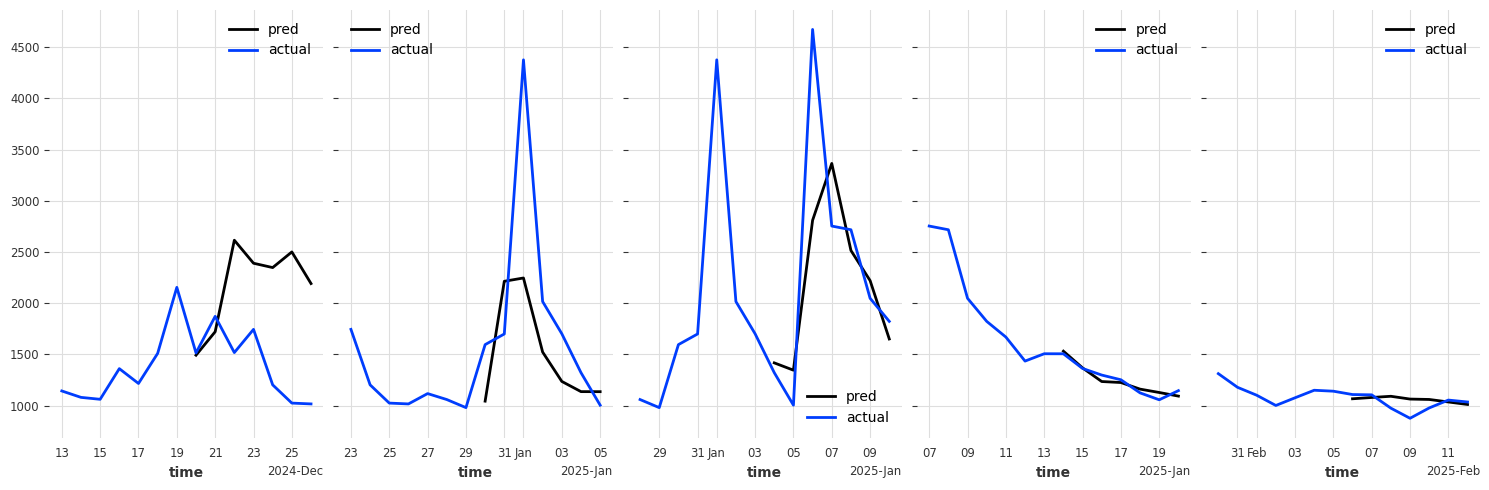

In [64]:
pred_horizon = 7

arbitrary_breakpoints = [10, 20, 25, 35, 58]  # test set has 70 points
fig, axes = plt.subplots(1, len(arbitrary_breakpoints), figsize=(15, 5), sharey=True)
for i, n_split in enumerate(arbitrary_breakpoints):
    test_in, test_out = test.split_before(n_split)

    predicted_inflow = xgb.predict(
        series=test_in, n=pred_horizon, future_covariates=test_covariates
    )

    predicted_inflow = TimeSeries.from_series(
        predicted_inflow.pd_series().apply(lambda x: np.exp(x) - 1)
    )

    actual_inflow = TimeSeries.from_series(
        test_in.append(test_out[predicted_inflow.time_index])
        .pd_series()
        .apply(lambda x: np.exp(x) - 1)
    ).slice_n_points_before(end_ts=predicted_inflow.time_index[-1], n=14)

    predicted_inflow.plot(label="pred", ax=axes[i])
    actual_inflow.plot(label="actual", ax=axes[i])

plt.tight_layout()

In [65]:
rmse(predicted_inflow, actual_inflow)

91.66376602866464

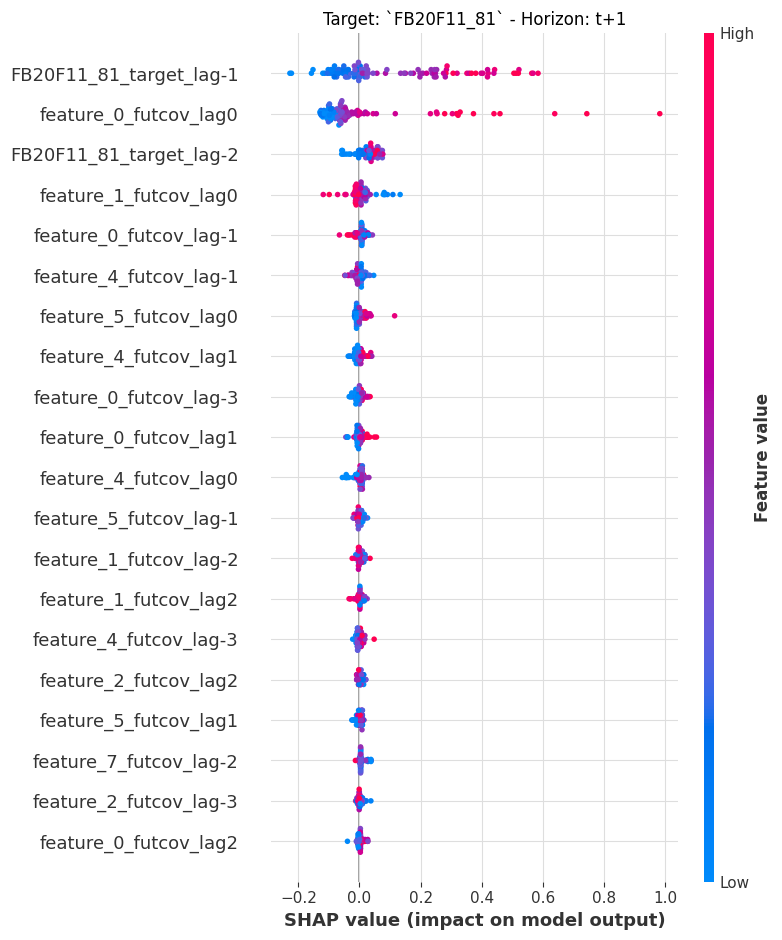

In [66]:
from darts.explainability.shap_explainer import ShapExplainer

shap_explain = ShapExplainer(
    xgb, background_series=train[0], background_future_covariates=train_covariates[0]
)
results = shap_explain.explain()
shap_explain.summary_plot();